In [23]:
import re
import numpy as np
import datetime

import pandas as pd

import struct

import matplotlib
%matplotlib widget

import matplotlib.pyplot as plt

In [ ]:
with open('/mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1711/drone/20251201_171135_drone.dat', 'rb') as f:
        data = f.read()

out = re.split(b'(?=\\x55)', data)

In [24]:
out_csv = pd.read_csv("data.csv")

/tmp/ipykernel_1555398/540433528.py:1: DtypeWarning: Columns (49,50,119,120,172,173,174,175,176,177,178,179,180,181,287,288,358,359,386,388,390,391,392,454) have mixed types. Specify dtype option on import or set low_memory=False.
  out_csv = pd.read_csv("data.csv")


In [3]:
# Parse the fields from the decrypted payload
def parse_payload(payload):
    # Extract fields based on the given offsets and types
    fields = {}
    fields['date'], fields['time'] = struct.unpack_from("<II", payload, 0)
    fields['longitude'] = struct.unpack_from("<i", payload, 8)[0] / 1.0E7
    fields['latitude'] = struct.unpack_from("<i", payload, 12)[0] / 1.0E7
    fields['heightMSL'] = struct.unpack_from("<i", payload, 16)[0] / 1000.0
    fields['velN'] = struct.unpack_from("<f", payload, 20)[0] / 100.0
    fields['velE'] = struct.unpack_from("<f", payload, 24)[0] / 100.0
    fields['velD'] = struct.unpack_from("<f", payload, 28)[0] / 100.0
    fields['hdop'] = struct.unpack_from("<f", payload, 32)[0]
    fields['pdop'] = struct.unpack_from("<f", payload, 36)[0]
    fields['hacc'] = struct.unpack_from("<f", payload, 40)[0]
    fields['sacc'] = struct.unpack_from("<f", payload, 44)[0]
    fields['numGPS'] = struct.unpack_from("<I", payload, 56)[0]
    fields['numGLN'] = struct.unpack_from("<I", payload, 60)[0]
    fields['numSV'] = struct.unpack_from("<H", payload, 64)[0]

    return fields

In [16]:
results = {}

# We don't need 'count' anymore for the dictionary logic
for m in out:
      # The XOR key from the header
    
    if len(m) > 10:
        header = m[:10]
        encrypted_payload = m[10:]
        key = header[6]
        t, = struct.unpack('<H', m[4:6])

        if t == 2096:
            decrypted_payload = bytearray(b ^ key for b in encrypted_payload)
            if len(decrypted_payload) > 64:
                res = parse_payload(decrypted_payload)
                res["tick"] = struct.unpack('<I', m[6:10])[0]

                # Iterate through the NEW mini-dictionary (res)
                for k, v in res.items():
                # .setdefault checks if 'k' is in results. 
                # If NOT, it creates it with an empty list [].
                # Then we .append(v) to that list.
                    results.setdefault(k, []).append(v)

In [18]:
if 'date' in results and 'time' in results:
    
    timestamps = []
    
    # zip() lets us loop over date and time lists simultaneously
    for d, t in zip(results['date'], results['time']):
        
        # Combine date and time strings (Adjust logic if d/t are not strings)
        full_string = f"{d} {t}" 
        
        # Define the format matching your data 
        # %Y=Year, %m=Month, %d=Day, %H=Hour, %M=Minute, %S=Second
        fmt = "%Y%m%d %H%M%S" 
        
        try:
            # Create datetime object
            dt_object = datetime.datetime.strptime(full_string, fmt)
            
            # Convert to Linux Timestamp (integer)
            timestamps.append(int(dt_object.timestamp()))
            
        except ValueError:
            # Handle cases where data might be malformed
            timestamps.append(None) 

    # Save the new list back to the dictionary
    results['timestamp'] = timestamps

In [38]:
timestamps = []
for d, t in zip(out_csv["GPS:Date"], out_csv["GPS:Time"]):
        
        # Combine date and time strings (Adjust logic if d/t are not strings)
        
        
        try:
            # Create datetime object
            full_string = f"{int(d)} {int(t)}"

            fmt = "%Y%m%d %H%M%S" 
            dt_object = datetime.datetime.strptime(full_string, fmt)
            
            # Convert to Linux Timestamp (integer)
            timestamps.append(int(dt_object.timestamp()))
            
        except ValueError:
            # Handle cases where data might be malformed
            timestamps.append(None) 

out_csv["Timestamp"] = timestamps

In [36]:
out_csv["GPS:Time"]

0            NaN
1       170821.0
2       170821.0
3       170821.0
4       170821.0
          ...   
7247    172030.0
7248    172030.0
7249    172030.0
7250    172030.0
7251    172030.0
Name: GPS:Time, Length: 7252, dtype: float64

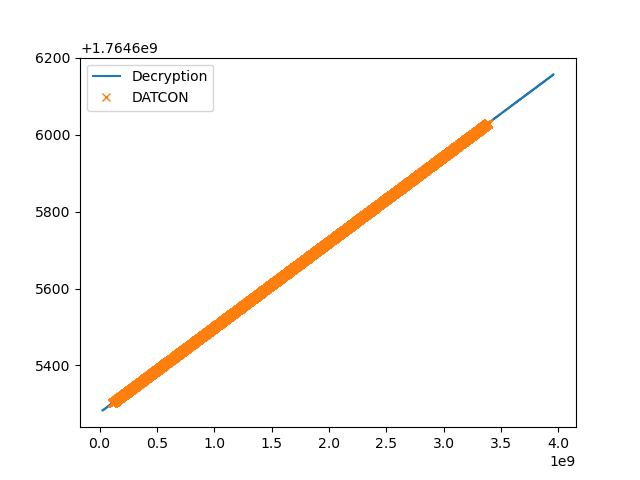

In [47]:
plt.figure()
plt.plot(results["tick"], results["timestamp"], label='Decryption')
plt.plot(out_csv["Clock:Tick#"], out_csv["Timestamp"], 'x', label = "DATCON")
plt.legend()

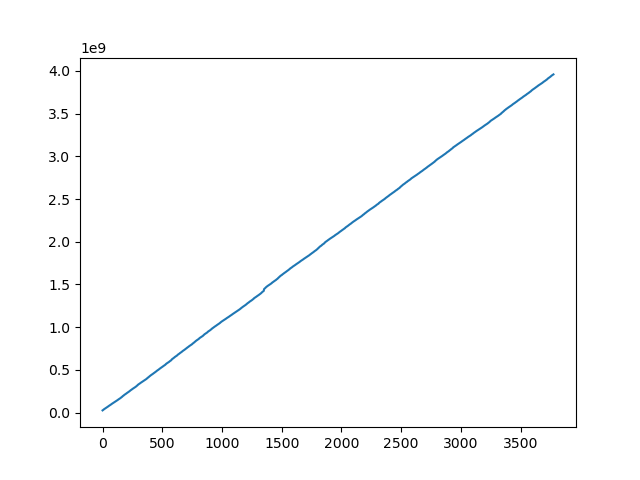

In [20]:
plt.figure()
plt.plot(results["tick"])

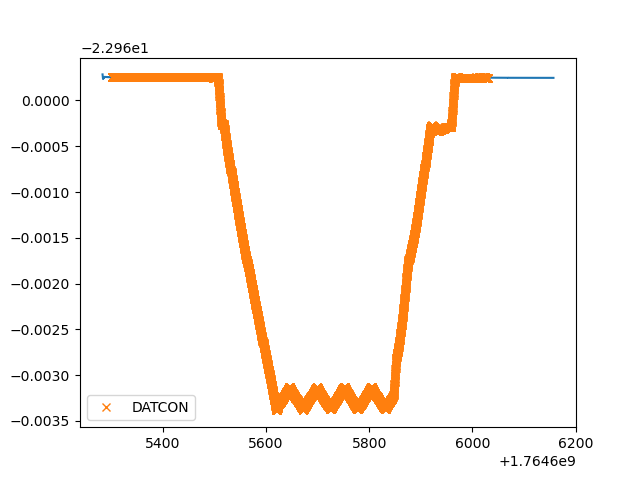

In [44]:
plt.figure()
plt.plot(results["timestamp"], results["latitude"])
plt.plot(out_csv["Timestamp"], out_csv["GPS:Lat[degrees]"], 'x', label = "DATCON")
plt.legend()

In [45]:
out_csv["GPS:dateTimeStamp"]

0                        NaN
1       2025-12-01T17:08:21Z
2       2025-12-01T17:08:21Z
3       2025-12-01T17:08:21Z
4       2025-12-01T17:08:21Z
                ...         
7247    2025-12-01T17:20:30Z
7248    2025-12-01T17:20:30Z
7249    2025-12-01T17:20:30Z
7250    2025-12-01T17:20:30Z
7251    2025-12-01T17:20:30Z
Name: GPS:dateTimeStamp, Length: 7252, dtype: object

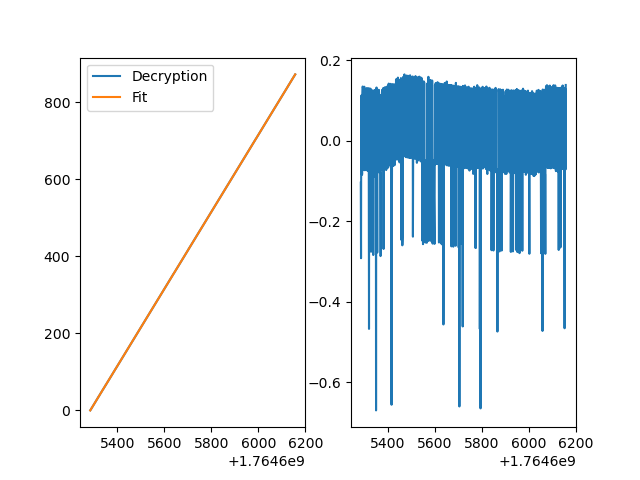

In [68]:
diff = np.diff(results["timestamp"])
idx, = np.where(diff > 0.7)

times = np.array(results["timestamp"])[idx + 1]
ticks = (np.array(results["tick"])[idx + 1]-np.array(results["tick"])[idx + 1][0]) / 4500000

m, c = np.polyfit(times, ticks, 1)

residuals = m * times + c - ticks

idx_lower = np.quantile(residuals, 0.95)

fig, ax = plt.subplots(1, 2)
ax[0].plot(times, ticks, label='Decryption')
ax[0].plot(times, m * times + c, label='Fit')

ax[0].legend()

ax[1].plot(times,  residuals)

In [76]:
vals, = np.where(residuals > np.quantile(residuals, 0.99))
np.average(residuals[vals])

np.float64(0.16128926151869413)

ok
LOADING DATA

1. Loading from DAT file...


2026-01-19 18:17:39,081 - pils.drones.DJIDrone - INFO - Tick unwrap at index 4009: 4,294,296,476 -> 206,394 (adding offset 2^32, total offset: 4,294,967,296)
2026-01-19 18:17:39,082 - pils.drones.DJIDrone - INFO - Loaded 7114 GPS messages from DAT file
2026-01-19 18:17:39,091 - pils.drones.DJIDrone - INFO - Tick unwrap at index 3705: 4,294,110,891 -> 43,735 (adding offset 2^32, total offset: 4,294,967,296)
2026-01-19 18:17:39,091 - pils.drones.DJIDrone - INFO - Loaded 6625 RTK messages from DAT file
2026-01-19 18:17:39,204 - pils.drones.DJIDrone - INFO - Converting timestamps to milliseconds
2026-01-19 18:17:39,205 - pils.drones.DJIDrone - INFO - Target ticks: 8276, 150124830.24 to 7597808959.24
2026-01-19 18:17:39,335 - pils.drones.DJIDrone - INFO - Converting timestamps to milliseconds


shape: (6_983,)
Series: 'datetime' [str]
[
	"2025-12-01 14:59:31"
	"2025-12-01 14:59:31"
	"2025-12-01 14:59:31"
	"2025-12-01 14:59:31"
	"2025-12-01 14:59:32"
	"2025-12-01 14:59:32"
	"2025-12-01 14:59:32"
	"2025-12-01 14:59:32"
	"2025-12-01 14:59:32"
	"2025-12-01 14:59:33"
	…
	"2025-12-01 15:27:03"
	"2025-12-01 15:27:03"
	"2025-12-01 15:27:03"
	"2025-12-01 15:27:04"
	"2025-12-01 15:27:04"
	"2025-12-01 15:27:04"
	"2025-12-01 15:27:04"
	"2025-12-01 15:27:05"
	"2025-12-01 15:27:05"
	"2025-12-01 15:27:05"
]

2. Loading from CSV file (DATCON)...


2026-01-19 18:17:39,549 - pils.drones.DJIDrone - INFO - Target ticks: 8276, 150124830.24 to 7597808959.24



Aligned Dataframe shape: (8276, 38)

Corrected Tick and Correct Timestamp (High Precision):
shape: (8_276, 3)
┌────────────────┬───────────────────┬─────────────────────────┐
│ corrected_tick ┆ correct_timestamp ┆ datetime_converted      │
│ ---            ┆ ---               ┆ ---                     │
│ f64            ┆ f64               ┆ datetime[ms]            │
╞════════════════╪═══════════════════╪═════════════════════════╡
│ 1.5012e8       ┆ 1.7646e9          ┆ 2025-12-01 14:59:31     │
│ 1.5102e8       ┆ 1.7646e9          ┆ 2025-12-01 14:59:31.200 │
│ 1.5192e8       ┆ 1.7646e9          ┆ 2025-12-01 14:59:31.400 │
│ 1.5282e8       ┆ 1.7646e9          ┆ 2025-12-01 14:59:31.600 │
│ 1.5372e8       ┆ 1.7646e9          ┆ 2025-12-01 14:59:31.800 │
│ …              ┆ …                 ┆ …                       │
│ 7.5940e9       ┆ 1.7646e9          ┆ 2025-12-01 15:27:05.200 │
│ 7.5949e9       ┆ 1.7646e9          ┆ 2025-12-01 15:27:05.400 │
│ 7.5958e9       ┆ 1.7646e9          ┆ 2025-

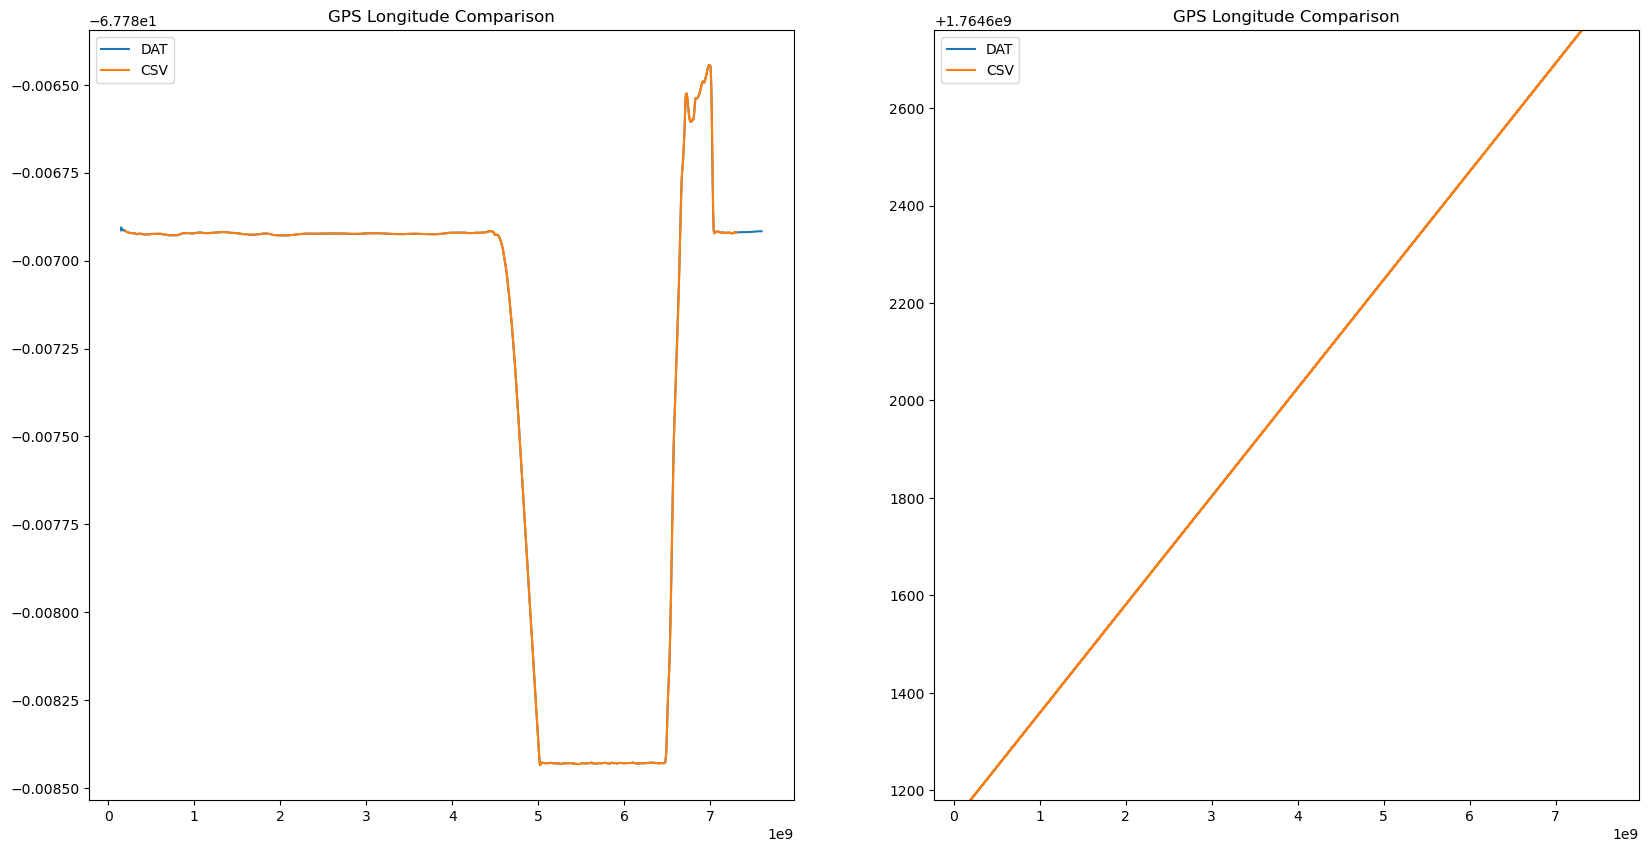

In [8]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import polars as pl


from pils.drones.DJIDrone import DJIDrone

modules_to_remove = [mod for mod in sys.modules.keys() if mod.startswith('pils')]
for mod in modules_to_remove:
    del sys.modules[mod]


from pils.drones.DJIDrone import DJIDrone

print("ok")
base_path = Path(
    "/mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1515/drone"
)

dat_file = base_path / "20251201_151517_drone.dat"
csv_file = "data_1515.csv"

print("=" * 80)
print("LOADING DATA")
print("=" * 80)

# Load DAT file
print("\n1. Loading from DAT file...")
drone_dat = DJIDrone(dat_file)
drone_dat.load_data(use_dat=True)

gps_data_df = drone_dat.data["GPS"]

with pl.Config(tbl_rows=20):
    print(gps_data_df["datetime"])

# Load CSV file
print("\n2. Loading from CSV file (DATCON)...")
drone_csv = DJIDrone(csv_file)
drone_csv.load_data(use_dat=False, cols=None)  # Load all columns
csv_data = drone_csv.data["CSV"]

fig = plt.figure(figsize=(20, 10))

# Plot 1: GPS Longitude vs Datetime - Compare DAT and CSV
ax1 = plt.subplot(1, 2, 1)
ax1.plot(gps_data_df["tick"], gps_data_df["GPS:longitude"], label="DAT")
ax1.plot(csv_data["Clock:Tick#"], csv_data["GPS:Long[degrees]"], label="CSV")
ax1.set_title("GPS Longitude Comparison")
ax1.legend()

ax2 = plt.subplot(1, 2, 2)
ax2.plot(gps_data_df["tick"], gps_data_df["timestamp"], label="DAT")
ax2.plot(csv_data["Clock:Tick#"], csv_data["timestamp"], label="CSV")
ax2.set_title("GPS Longitude Comparison")
ax2.set_ylim(csv_data["timestamp"].min(), csv_data["timestamp"].max())
ax2.legend()

plt.savefig("compare_dat_csv.png")

aligned = drone_dat.align_datfile()

print("\nAligned Dataframe shape:", aligned.shape)

print("\nCorrected Tick and Correct Timestamp (High Precision):")

print(aligned.select(["corrected_tick", "correct_timestamp", "datetime_converted"]))


In [10]:
aligned["correct_timestamp"].min(), aligned["correct_timestamp"].max()

(1764601171.0, 1764602826.0)